Dataset link

https://www.kaggle.com/datasets/adityajn105/flickr8k

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

In [1]:
import os
import pickle
import numpy as np
import re
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
## Extracting Image Features using VGG16
vgg_model = VGG16(weights='imagenet')

In [3]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
## Load the Captions Data
captions_data_file = open("flickr/captions.txt")
captions_data = captions_data_file.readlines()
captions_data_file.close()

In [46]:
captions_data[:10]

['image,caption\n',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n']

In [47]:
file_types = []
for line in captions_data:
    image_formats = ['.jpg','.png','.bmp']
    for img_f in image_formats:
        if img_f in line and img_f not in file_types:
            file_types.append(img_f)

In [48]:
file_types

['.jpg']

In [83]:
image_captions = {}
for line in captions_data:
    line = line.strip()
    for file_type in file_types:
        if file_type in line:
            image_file, caption = line.split(file_type)
            caption = caption.replace(".\n",'').strip()
            caption = re.sub(r"['\",-]", '', caption)
            if caption.startswith(","):
                caption = caption[1:]
            if caption.endswith(" ."):
                caption = caption[:-2]
            if image_file+file_type in image_captions:
                image_captions[image_file+file_type].append("startseq "+caption.lower()+" endseq")
            else:
                image_captions[image_file+file_type] = ["startseq "+caption.lower()+" endseq"]

In [84]:
image_captions

{'1000268201_693b08cb0e.jpg': ['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
  'startseq a girl going into a wooden building endseq',
  'startseq a little girl climbing into a wooden playhouse endseq',
  'startseq a little girl climbing the stairs to her playhouse endseq',
  'startseq a little girl in a pink dress going into a wooden cabin endseq'],
 '1001773457_577c3a7d70.jpg': ['startseq a black dog and a spotted dog are fighting endseq',
  'startseq a black dog and a tricolored dog playing with each other on the road endseq',
  'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8.jpg': ['startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq',
  'startseq a little g

In [65]:
len(image_captions)

8091

In [66]:
len(os.listdir('flickr/Images/'))

8091

In [60]:
total_captions = []
for caption in image_captions.values():
    total_captions.extend(caption)

In [62]:
caption_tokenizer = Tokenizer()
caption_tokenizer.fit_on_texts(total_captions)

In [63]:
vocab_size = len(caption_tokenizer.index_word)

In [64]:
vocab_size

4498

In [67]:
max_words_length = max(len(caption.split()) for caption in total_captions)

In [68]:
max_words_length

38

In [117]:
image_data_training = image_dataset_from_directory("flickr/Images/",
                                          validation_split = 0.2,
                                          subset = 'training',
                                          batch_size=32,
                                          seed=77,
                                          label_mode = None,
                                          image_size=(224,224),
                                          shuffle=False
                                         )
image_data_testing = image_dataset_from_directory("flickr/Images/",
                                          validation_split = 0.2,
                                          subset = 'validation',
                                          batch_size=32,
                                          seed=77,
                                          label_mode = None,
                                          image_size=(224,224),
                                          shuffle=False
                                         )

Found 8091 files belonging to 1 classes.
Using 6473 files for training.
Found 8091 files belonging to 1 classes.
Using 1618 files for validation.


In [118]:
training_captions = {}
testing_captions = {}
for file_name in image_data_training.file_paths:
    file_path = file_name.split("/")[-1]
    if file_path in image_captions:
        training_captions[file_path] = image_captions[file_path]
    else:
        print("Warning: a file not found", file_path)
for file_name in image_data_testing.file_paths:
    file_path = file_name.split("/")[-1]
    if file_path in image_captions:
        testing_captions[file_path] = image_captions[file_path] 
    else:
        print("Warning: a file not found", file_path)

In [119]:
training_captions

{'1000268201_693b08cb0e.jpg': ['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
  'startseq a girl going into a wooden building endseq',
  'startseq a little girl climbing into a wooden playhouse endseq',
  'startseq a little girl climbing the stairs to her playhouse endseq',
  'startseq a little girl in a pink dress going into a wooden cabin endseq'],
 '1001773457_577c3a7d70.jpg': ['startseq a black dog and a spotted dog are fighting endseq',
  'startseq a black dog and a tricolored dog playing with each other on the road endseq',
  'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8.jpg': ['startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq',
  'startseq a little g

In [245]:
def tokenize_captions(caption_dict, tokenizer, max_len):
    result_dict = {}
    for key in caption_dict.keys():
        result_dict[key] = tokenizer.texts_to_sequences(caption_dict[key])
    return result_dict

In [246]:
training_seq_caption = tokenize_captions(training_captions, caption_tokenizer, max_words_length)
testing_seq_caption = tokenize_captions(testing_captions, caption_tokenizer, max_words_length)

In [662]:
def get_dict_cap(dictionary, batch_size, max_len, file_path='flickr/Images/'):
    n = 0
    X1,X2,Y = list(), list(), list()
    while True:
        for key in dictionary:
            seq_data = dictionary[key]
            img_array = preprocess_input(img_to_array(load_img(file_path+key, target_size=(224,224))))
            for seq in seq_data:
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    try:
                        out_seq = to_categorical([out_seq], num_classes=vocab_size+1)[0]
                    except:
                        print(out_seq)
                        print(seq)
                    X1.append(in_seq)
                    X2.append(img_array)
                    Y.append(out_seq)
            n+=1
            if n>=batch_size:
                yield X1,X2,Y
                n=0
                X1.clear()
                X2.clear()
                Y.clear()

In [684]:
batch_size = 32
total_batches_train = len(image_data_training.file_paths)//batch_size
total_batches_test = len(image_data_testing.file_paths)//batch_size
train_caption_gen = get_dict_cap(training_seq_caption, batch_size, max_words_length)
test_caption_gen = get_dict_cap(testing_seq_caption, batch_size, max_words_length)

In [590]:
## MOdel
## LSTM Model
lstm_input  = Input(shape=(max_words_length,))
lstm_e1 = Embedding(vocab_size+1, 50, mask_zero=True)(lstm_input)
lstm_rnn1 = LSTM(256, return_sequences=True)(lstm_e1)
lstm_d1 = Dropout(0.2)(lstm_rnn1)
lstm_rnn2 = LSTM(100)(lstm_d1)

In [9]:
vgg_model.layers[-2].output

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [15]:
vgg_input = Sequential()
#vgg_input = Sequential()
for layer in vgg_model.layers[:-1]:
    vgg_input.add(layer)

In [17]:
vgg_input.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [591]:
dense1 = Dense(100, activation='relu')(vgg_model.layers[-2].output)

In [592]:
concat = add([lstm_rnn2, dense1])
dense2 = Dense(50, activation='relu')(concat)
outputs = Dense(vocab_size+1, activation='softmax')(dense2)

In [593]:
caption_model = Model(inputs=[vgg_model.inputs, lstm_input], outputs=outputs)

In [596]:
caption_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [597]:
vgg_input.trainable = False

In [598]:
caption_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

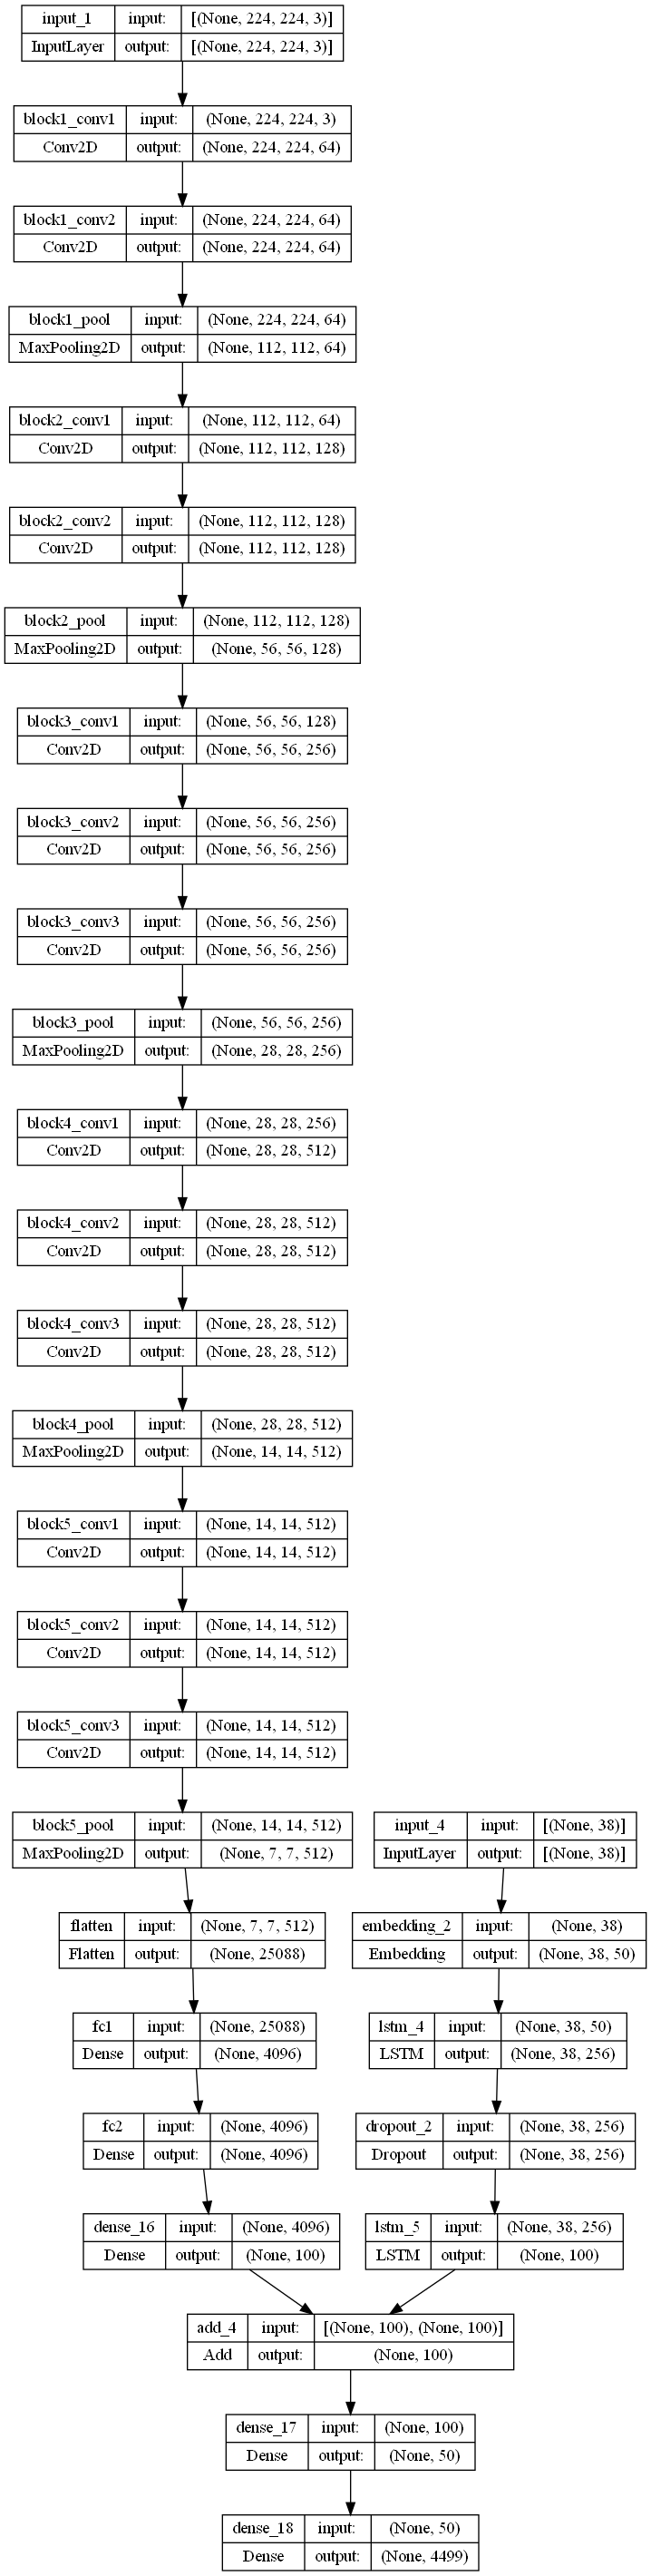

In [594]:
plot_model(caption_model, show_shapes=True)

In [640]:
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [686]:
epochs = 50

for i in range(epochs):
    # create data generator
    X1, X2, Y = next(train_caption_gen)
    X1, X2, Y = np.array(X1), np.array(X2), np.array(Y)
    caption_model.fit([X2,X1],Y, epochs=i+1, verbose=1, workers=4, initial_epoch=i-1)

57/57 [==============================] - 499s 9s/step - loss: 4.8506
Epoch 1/2
58/58 [==============================] - 507s 9s/step - loss: 4.2264
Epoch 2/2
58/58 [==============================] - 513s 9s/step - loss: 3.8359
Epoch 2/3
60/60 [==============================] - 524s 9s/step - loss: 5.3535
Epoch 3/3
60/60 [==============================] - 526s 9s/step - loss: 4.7282
Epoch 3/4
58/58 [==============================] - 508s 9s/step - loss: 4.9776
Epoch 4/4
58/58 [==============================] - 512s 9s/step - loss: 4.6408
Epoch 4/5
62/62 [==============================] - 549s 9s/step - loss: 4.9551
Epoch 5/5
62/62 [==============================] - 566s 9s/step - loss: 4.6220
Epoch 5/6
60/60 [==============================] - 529s 9s/step - loss: 4.9855
Epoch 6/6
60/60 [==============================] - 526s 9s/step - loss: 4.6458
Epoch 6/7
61/61 [==============================] - 568s 9s/step - loss: 4.9658
Epoch 7/7
61/61 [==============================] - 554s 9s/ste

KeyboardInterrupt: 

In [687]:
caption_model.save("Models/Image_Caption.h5")

In [694]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        #print(image.shape)
        #print(sequence)
        yhat = model.predict([np.expand_dims(image,axis=0), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text.replace("startseq",'').replace("endseq",'')

In [702]:
from matplotlib import pyplot as plt
def generate_caption(image_name):
    image_original = img_to_array(load_img(image_name, target_size=(224,224)))
    image = preprocess_input(image_original)
    captions = image_captions[image_name.split("/")[-1]]
    print('******Actual*******')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(caption_model, image, caption_tokenizer, max_words_length)
    print('*******Predicted***********')
    print(y_pred)
    #print(image_original)
    plt.imshow(plt.imread(image_name))

******Actual*******
startseq a boy smiles in front of a stony wall in a city endseq
startseq a little boy is standing on the street while a man in overalls is working on a stone wall endseq
startseq a young boy runs aross the street endseq
startseq a young child is walking on a stone paved street with a metal pole and a man behind him endseq
startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq
*******Predicted***********
 a man in a shirt is is is is is is in a rock 


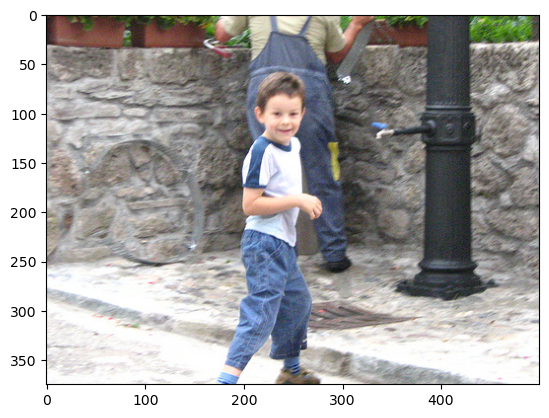

In [713]:
generate_caption(image_data_training.file_paths[8])

******Actual*******
startseq a black dog in water endseq
startseq a black dog standing in a shallow area of water on a rocky beach endseq
startseq a dog stands in a tide pool endseq
startseq a small black dog in the ocean with some rocks in the background endseq
startseq a small black dog plays in the water endseq
*******Predicted***********
 a black dog is running in a ball 


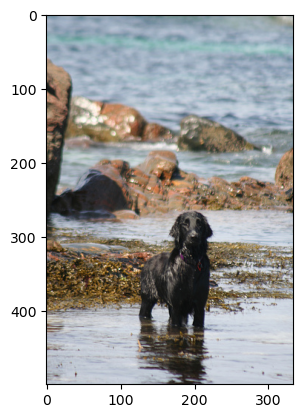

In [696]:
generate_caption(image_data_testing.file_paths[4])